# Structural time series (STS) model with Poisson likelihood

In [1]:
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt

import tensorflow_probability.substrates.jax as tfp
from tensorflow_probability.substrates.jax import bijectors as tfb
from tensorflow_probability.substrates.jax import distributions as tfd
import time

## Synthetic Data

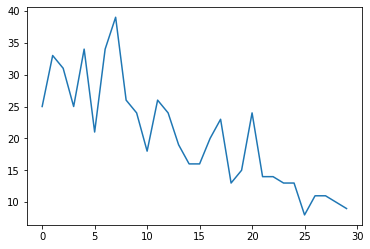

In [2]:
import numpy as np

num_timesteps = 30
observed_counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.2, size=num_timesteps))
observed_counts = observed_counts.astype(np.float32)
plt.plot(observed_counts)

## Implementation in [TFP](https://www.tensorflow.org/probability/examples/STS_approximate_inference_for_models_with_non_Gaussian_observations)

Instead of operating on the observed time series, the model operates on the series of Poisson rate
parameters that govern the observations, which is transformed to real values Softplus transformation
$y = \log(1 + \exp(x))$.

To use approximate inference for a non-Gaussian observation model, it encodes the STS model as a
TFP JointDistribution. The random variables in this joint distribution are the parameters of the
STS model, the time series of latent Poisson rates, and the observed counts.

It uses HMC (specifically, NUTS) to sample from the joint posterior over model parameters and latent
rates. This will be significantly slower than fitting a standard STS model with HMC, since in addition
to the model's (relatively small number of) parameters it also has to infer the entire series of
Poisson rates.

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

# Build STS model.
def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(
        observed_time_series=approximate_unconstrained_rates)
    return tfp.sts.Sum([trend],
                       observed_time_series=approximate_unconstrained_rates)

positive_bijector = tfb.Softplus()

approximate_unconstrained_rates = positive_bijector.inverse(
    tf.convert_to_tensor(observed_counts) + 0.01)

sts_model = build_model(approximate_unconstrained_rates)

2022-10-03 16:15:31.090117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-03 16:15:31.090134: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# To use Poisson likelihood, it encodes the STS model as a TFP JointDistribution
def sts_with_poisson_likelihood_model():
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)
        
    unconstrained_rates = yield sts_model.make_state_space_model(
        num_timesteps, param_vals)
    rate = positive_bijector.forward(unconstrained_rates[..., 0])
    observed_counts = yield tfd.Poisson(rate, name='observed_counts')
    
model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)
pinned_model = model.experimental_pin(observed_counts=observed_counts)
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2022-10-03 16:15:33.890117: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library


In [5]:
# Inference with HMC
num_results = int(500)
num_burnin_steps = int(100)

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tf.random.normal(part_shape)
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))

@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
        kernel=adaptive_sampler,
        current_state=initial_state,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        trace_fn=None)

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print(f"Inference ran in {t1-t0}s")

/home/xinglong/.local/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(
2022-10-03 16:15:37.731891: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Inference ran in 5.010897874832153s


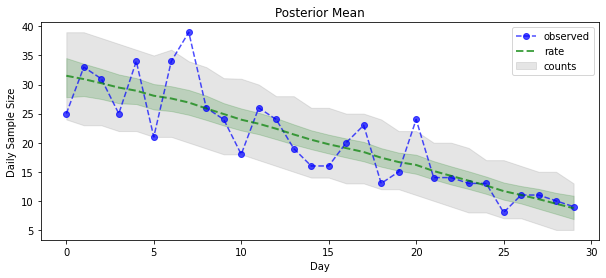

In [7]:
# Posterior Samples
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(observed_counts, color='blue', ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color='green', ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Daily Sample Size')
plt.title('Posterior Mean')
plt.legend()

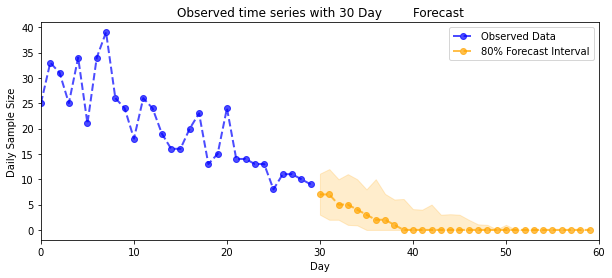

In [8]:
# Forecasting
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):
    
    unconstrained_rates_forecast_dist = tfp.sts.forecast(
        sts_model,
        observed_time_series=unconstrained_rate_samples,
        parameter_samples=posterior_params,
        num_steps_forecast=num_steps_forecast
        )
    rates_forecast_dist = tfd.TransformedDistribution(
        unconstrained_rates_forecast_dist, positive_bijector
        )
    sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
    sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

    return sampled_forecast_counts, sampled_latent_rates
    
forecast_samples, rate_samples = sample_forecasted_counts(
    sts_model, posterior_latent_rates=unconstrained_rate_samples,
    posterior_params=param_samples, num_steps_forecast=30, num_sampled_forecasts=100)

forecast_samples = np.squeeze(forecast_samples)

def plot_forecast_helper(data, forecast_samples, CI=90):
    """Plot the observed time series alongside the forecast."""
    plt.figure(figsize=(10, 4))
    forecast_median = np.median(forecast_samples, axis=0)

    num_steps = len(data)
    num_steps_forecast = forecast_median.shape[-1]

    plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='--', marker='o',
             label='Observed Data', alpha=0.7)

    forecast_steps = np.arange(num_steps, num_steps+num_steps_forecast)

    CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

    plt.plot(forecast_steps, forecast_median, lw=2, ls='--', marker='o', color='orange',
             label=str(CI) + '% Forecast Interval', alpha=0.7)
    plt.fill_between(forecast_steps, lower, upper, color='orange', alpha=0.2)

    plt.xlim([0, num_steps+num_steps_forecast])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)),\
                 max(np.max(forecast_samples), np.max(data))
    yrange = ymax-ymin
    plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day        Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.legend()
    
plot_forecast_helper(observed_counts, forecast_samples, CI=80)

## Implementation via CMGF